In [1]:
import pandas as pd
import time
from pynvml import *

pos_df = pd.read_csv(r"C:\Users\ASUS\Downloads\yelp_4_and_above")
print(len(pos_df))
# print(pos_df.head(1))
# print(pos_df.columns)

neg_df = pd.read_csv(r"C:\Users\ASUS\Downloads\yelp_2_and_below")
print(len(neg_df))
# print(neg_df.head(1))
print(neg_df.columns)



yelp_df = pd.concat([pos_df,neg_df])
yelp_df['sentiment'] = yelp_df['stars'].apply(lambda x: 1 if x >= 4 else 0)
print(yelp_df["stars"].value_counts())
print(yelp_df["sentiment"].value_counts())

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8100\558747981.py:3: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  from pynvml import *


5000
5000
Index(['Unnamed: 0', 'review_id', 'user_id', 'business_id', 'stars', 'useful',
       'funny', 'cool', 'text', 'date'],
      dtype='object')
stars
5.0    3185
1.0    2886
2.0    2114
4.0    1815
Name: count, dtype: int64
sentiment
1    5000
0    5000
Name: count, dtype: int64


In [2]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(yelp_df, test_size=0.2, random_state=42, stratify=yelp_df["sentiment"])

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")

Train size: 8000
Validation size: 2000


In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
# from datasets import load_dataset
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import re
import copy

train_texts = train_df["text"]
train_labels = train_df["sentiment"]
val_texts = val_df["text"]
val_labels = val_df["sentiment"]

def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text.split()

counter = Counter()
for text in train_texts:
    counter.update(tokenize(text))
print(f"counterlen: {len(counter)}")
vocab_size = 20000
vocab = {word: idx + 2 for idx, (word, _) in enumerate(counter.most_common(vocab_size))}
vocab["<pad>"] = 0
vocab["<unk>"] = 1

def numericalize(tokens):
    return [vocab.get(token, vocab["<unk>"]) for token in tokens]

class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [torch.tensor(numericalize(tokenize(t))) for t in texts]
        self.labels = torch.tensor(labels.tolist())
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

def collate_batch(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=vocab["<pad>"])
    return texts_padded, torch.tensor(labels)

train_data = IMDBDataset(train_texts, train_labels)
val_data = IMDBDataset(val_texts, val_labels)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=collate_batch)


counterlen: 26450


# Test dataset IMDB

In [5]:
IMDB_df = pd.read_csv(r"C:\Users\ASUS\Downloads\SC4001 Neural Network project\IMDB Dataset.csv")
print(len(IMDB_df))
print(IMDB_df.head())
IMDB_df["sentiment"] = IMDB_df["sentiment"].apply(lambda x: 1 if x == "positive" else 0)
test_texts = IMDB_df["review"]
test_labels = IMDB_df["sentiment"]
IMDB_data = IMDBDataset(test_texts, test_labels)
test_loader = DataLoader(IMDB_data, batch_size=32, shuffle=False, collate_fn=collate_batch)

50000
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


# GLOVE embeddings

In [6]:
from torchtext.vocab import GloVe
glove = GloVe(name="6B", dim=100)
embedding_dim = glove.dim

# Create embedding matrix
embedding_matrix = torch.zeros(len(vocab), embedding_dim)
for word, idx in vocab.items():
    if word in glove.stoi:
        embedding_matrix[idx] = glove[word]
    else:
        embedding_matrix[idx] = torch.randn(embedding_dim) * 0.05  # random init for OOV words

c:\Users\ASUS\anaconda3\envs\SC4001\Lib\site-packages\torchtext\vocab.py:432: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.itos, self.stoi, self.vectors, self.dim = to

# carbon tracker

In [15]:
import glob
from carbontracker.tracker import CarbonTracker
from carbontracker import parser as ct_parser

def find_ct_output_log(ct_dir, prefix:str | None = None, timeout_s: float = 3.0):
    search_roots = [os.path.abspath(ct_dir), os.path.abspath(os.getcwd())]
    deadline = time.time() + timeout_s
    best = None
    while time.time() <= deadline:
        candidates = []
        for root in search_roots:
            if os.path.isdir(root):
                candidates.extend(glob.glob(os.path.join(root, "**", "*carbontracker_output.log"), recursive=True))
        candidates = sorted(set(candidates), key=os.path.getmtime, reverse=True)
        if prefix:
            pref = [p for p in candidates if prefix in os.path.basename(p)]
            if pref:
                return pref[0]
        if candidates:
            return candidates[0]
        time.sleep(0.25)
    return best

def parse_carbontracker(ct_dir, prefix: str | None = None):
    output_log = None
    # Try official helper
    try:
        from carbontracker import parser as ct_parser
        output_log, _ = ct_parser.get_most_recent_logs(log_dir=ct_dir)
    except Exception:
        pass
    if not output_log or not os.path.exists(output_log):
        output_log = find_ct_output_log(ct_dir, prefix=prefix)
    if not output_log or not os.path.exists(output_log):
        return None, None, None, None

    with open(output_log, "r", encoding="utf-8", errors="ignore") as f:
        out_txt = f.read()
    try:
        from carbontracker import parser as ct_parser
        actual, pred = ct_parser.get_consumption(out_txt)
        cons = actual or pred
        if cons:
            e = cons.get("energy (kWh)")
            c = cons.get("co2eq (g)")
            d = cons.get("duration (s)")
            return (
                float(e) if e is not None else None,
                float(c) if c is not None else None,
                float(d) if d is not None else None,
                output_log,
            )
    except Exception:
        pass

    #regex fallback
    mE = re.search(r"Energy:\s*([0-9.eE+-]+)\s*kWh", out_txt)
    mC = re.search(r"CO2eq:\s*([0-9.eE+-]+)\s*g", out_txt)
    mT = re.search(r"Time:\s*([0-9:]+)", out_txt)

    energy_kwh = float(mE.group(1)) if mE else None
    co2_g      = float(mC.group(1)) if mC else None
    duration_s = None
    if mT:
        hh, mm, ss = (int(x) for x in mT.group(1).split(":"))
        duration_s = 3600*hh + 60*mm + ss

    return energy_kwh, co2_g, duration_s, output_log


import re, os, time
from carbontracker import parser as ct_parser

def parse_carbontracker_totals(ct_dir, prefix: str | None = None):
    output_log = None
    # Try official helper
    try:
        output_log, _ = ct_parser.get_most_recent_logs(log_dir=ct_dir)
    except Exception:
        pass

    if not output_log or not os.path.exists(output_log):
        # fallback to searching manually
        output_log = find_ct_output_log(ct_dir, prefix=prefix)
    if not output_log or not os.path.exists(output_log):
        return None, None, None, None

    with open(output_log, "r", encoding="utf-8", errors="ignore") as f:
        out_txt = f.read()

    # Try CarbonTracker parser first
    try:
        actual, pred = ct_parser.get_consumption(out_txt)
        cons = actual or pred
        if cons:
            energy = float(cons.get("energy (kWh)", 0))
            co2 = float(cons.get("co2eq (g)", 0))
            duration = float(cons.get("duration (s)", 0))
            return energy, co2, duration, output_log
    except Exception:
        pass

    # Regex fallback for summary totals at the end of log
    mE = re.findall(r"Energy:\s*([0-9.eE+-]+)\s*kWh", out_txt)
    mC = re.findall(r"CO2eq:\s*([0-9.eE+-]+)\s*g", out_txt)
    mT = re.findall(r"Time:\s*([0-9:]+)", out_txt)

    # take last occurrence (final totals)
    energy = float(mE[-1]) if mE else None
    co2 = float(mC[-1]) if mC else None
    duration_s = None
    if mT:
        hh, mm, ss = (int(x) for x in mT[-1].split(":"))
        duration_s = hh*3600 + mm*60 + ss

    return energy, co2, duration_s, output_log


In [22]:
import os
import re
from pathlib import Path

def get_latest_carbontracker_output(log_dir="carbon_logs"):
    log_dir = Path(log_dir)

    # Match .log or any extension
    files = list(log_dir.glob("*carbontracker_output*"))
    if not files:
        raise FileNotFoundError("No files containing 'carbontracker_output' found.")

    latest_file = max(files, key=lambda f: f.stat().st_mtime)
    return latest_file


def parse_carbontracker_log(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        text = f.read()

    energy_pattern = r"Energy:\s*([0-9.]+)\s*kWh"
    co2_pattern = r"CO2eq:\s*([0-9.]+)\s*g"
    car_pattern = r"equivalent to:\s*([0-9.]+)\s*km travelled by car"

    energy = re.search(energy_pattern, text)
    co2 = re.search(co2_pattern, text)
    car_distance = re.search(car_pattern, text)

    return {
        "energy_kWh": float(energy.group(1)) if energy else None,
        "co2_grams": float(co2.group(1)) if co2 else None,
        "car_km": float(car_distance.group(1)) if car_distance else None
    }



# Preparing training code

In [25]:
from sklearn.metrics import accuracy_score, f1_score
from pynvml import *
import time

import subprocess

def get_power_usage_watts():
    try:
        
        result = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=power.draw", "--format=csv,noheader,nounits"]
        )
        return float(result.strip())
    except Exception as e:
        print("Error reading GPU power:", e)
        return 0.0

def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    start_time = time.time()
    start_power = get_power_usage_watts()

    for texts, labels in dataloader:
        texts, labels = texts.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total

    end_time = time.time()
    end_power = get_power_usage_watts()

    elapsed_time = end_time - start_time
    avg_power = (start_power + end_power) / 2  # rough average
    energy_joules = avg_power * elapsed_time

    return avg_loss, accuracy, energy_joules

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)

            loss = criterion(outputs, labels)
            batch_size = labels.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds).cpu()
    all_labels = torch.cat(all_labels).cpu()

    avg_loss = total_loss / total_samples
    acc = (all_preds == all_labels).float().mean().item()
    f1 = f1_score(all_labels.numpy(), all_preds.numpy())

    return avg_loss, acc, f1

# BiLSTM

In [26]:
class biLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, method="last", dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab["<pad>"])
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,1))
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.method = method  
        
    def forward(self, text):
        embedded = self.embedding(text)  
        output, (hidden, _) = self.lstm(embedded)

        if self.method == "last":
            hidden_fw = hidden[-2, :, :]  
            hidden_bw = hidden[-1, :, :]  
            hidden_cat = torch.cat((hidden_fw, hidden_bw), dim=1)  
            
        elif self.method == "avg":
            hidden_cat = torch.mean(output, dim=1)  
        
        elif self.method == "max":
            hidden_cat, _ = torch.max(output, dim=1)

        elif self.method == "2dmaxpool":
            output_4d = output.unsqueeze(1)
            pooled = self.maxpool(output_4d) 
            hidden_cat = pooled.squeeze(1).max(dim=1)[0]

        hidden_cat = self.dropout(hidden_cat)
        return self.fc(hidden_cat)

# Test code


In [ ]:
import torch
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import pandas as pd

def test_worst(model, dataloader, criterion, return_preds=False, text_dataset=None, label_names= ["Negative", "Positive"]):
    model.eval()
    total_loss, total_samples = 0.0, 0
    all_preds, all_labels, all_probs, all_texts = [], [], [], []

    with torch.inference_mode():
        for i, (texts, labels) in enumerate(dataloader):
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)

            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())
            
            if text_dataset is not None:
                all_texts.extend(text_dataset[i * dataloader.batch_size : i * dataloader.batch_size + len(labels)])

            if i % 10000 == 0:
                print(f"Processed {total_samples:,} samples...")

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_probs = torch.cat(all_probs)

    avg_loss = total_loss / total_samples
    acc = (all_preds == all_labels).float().mean().item()
    f1 = f1_score(all_labels, all_preds, average="weighted")

    cm = confusion_matrix(all_labels, all_preds) if return_preds else None

    wrong_mask = all_preds != all_labels
    wrong_indices = torch.where(wrong_mask)[0]

    rows = []
    for idx in wrong_indices:
        true_label = int(all_labels[idx])
        pred_label = int(all_preds[idx])
        pred_conf = float(all_probs[idx, pred_label])
        true_conf = float(all_probs[idx, true_label])
        text = all_texts[idx] if text_dataset is not None else None

        rows.append({
            "index": int(idx),
            "true_label": label_names[true_label] if label_names else true_label,
            "pred_label": label_names[pred_label] if label_names else pred_label,
            "true_conf": true_conf,
            "pred_conf": pred_conf,
            "text": text
        })

    df_wrong = pd.DataFrame(rows)

    df_sorted = df_wrong.sort_values(["true_label", "pred_conf"], ascending=[True, False]).reset_index(drop=True)

    return {
        "avg_loss": avg_loss,
        "acc": acc,
        "f1": f1,
        "confusion_matrix": cm,
        "labels": all_labels.numpy(),
        "preds": all_preds.numpy(),
        "misclassified": df_sorted
    }

In [34]:
def hyperparam_tuning(lr, optimiser, weight_decay, method):
    NUM_RUNS = 3
    all_results = []

    for run in range(1, NUM_RUNS + 1):
        print(f"\n{'='*25}\nStarting training run {run}\n{'='*25}")

        model = biLSTM(
            vocab_size=embedding_matrix.shape[0],
            embed_dim=embedding_matrix.shape[1],
            hidden_dim=128,
            output_dim=2,
            method=method
        ).to(device)

        # Load GloVe weights (frozen)
        model.embedding.weight.data.copy_(embedding_matrix)
        model.embedding.weight.requires_grad = False

        criterion = nn.CrossEntropyLoss()

        if optimiser.lower() == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimiser.lower() == "adamw":
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimiser.lower() == "sgd":
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9)
        

        best_acc = 0.0
        best_model_state = None
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies, val_f1s = [], [], []

        patience = 5
        best_val_loss = float('inf')
        epochs_no_improve = 0
        total_energy_usage = 0.0

        for epoch in range(50):
            train_loss, train_acc, energy_used = train_epoch(model, train_loader, optimizer, criterion)
            val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            val_f1s.append(val_f1)
            total_energy_usage += energy_used

            print(f"Epoch {epoch+1:02d}: "
                f"train loss={train_loss:.4f}, val loss={val_loss:.4f}, "
                f"train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, val_f1={val_f1:.4f}")

            if val_acc > best_acc:
                best_acc = val_acc
                best_model_state = copy.deepcopy(model.state_dict())
                print(f"New best accuracy: {best_acc:.4f} at epoch {epoch+1}, saving model.")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                print(f"No improvement in val loss for {epochs_no_improve} epochs.")
                if epochs_no_improve >= patience:
                    print(f"Early stopping triggered at epoch {epoch+1}.")
                    break

        model.load_state_dict(best_model_state)
        model.eval() 

        test_results = test_worst(
            model,
            test_loader,
            criterion,
            return_preds=True,
            text_dataset=test_texts,
        )

        all_results.append({
            "run": run,
            "num_epochs": epoch+1,
            "best_acc": best_acc,
            "total_energy": total_energy_usage,
            "train_losses": train_losses,
            "train_accuracies":train_accuracies,
            "val_accuracies":val_accuracies,
            "val_losses": val_losses,
            "val_f1s": val_f1s,
            "test_acc": test_results["acc"],
            "test_f1": test_results["f1"]
        })
    return all_results

In [28]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Tuning learning rate

In [ ]:
learning_rates = [0.0001, 0.0005, 0.001]

best_avg_acc = 0.0
best_lr = None
all_lr_results = {}

for lr in learning_rates:
    print(f"\n{'='*40}\nTesting learning rate: {lr}\n{'='*40}")
    
    results = hyperparam_tuning(lr=lr, optimiser="adam", weight_decay=0.0, method="last")
    
    test_accs = [res["test_acc"] for res in results]
    test_f1s = [res["test_f1"] for res in results]
    
    avg_acc = sum(test_accs) / len(test_accs)
    avg_f1 = sum(test_f1s) / len(test_f1s)
    
    print(f"Test Accuracies for lr={lr}: {test_accs}")
    print(f"Test F1 Scores for lr={lr}: {test_f1s}")
    print(f"Average Test Accuracy: {avg_acc:.4f}, Average Test F1: {avg_f1:.4f}\n")
    
    all_lr_results[lr] = {
        "test_accs": test_accs,
        "test_f1s": test_f1s,
        "avg_acc": avg_acc,
        "avg_f1": avg_f1
    }
    
    # Update best configuration
    if avg_acc > best_avg_acc:
        best_avg_acc = avg_acc
        best_lr = lr

print(f"\n{'='*40}\nBest learning rate: {best_lr} with average test accuracy: {best_avg_acc:.4f}")



Testing learning rate: 0.0001

Starting training run 1
Epoch 01: train loss=0.6625, val loss=0.5303, train_acc=0.6114, val_acc=0.7585, val_f1=0.7512
New best accuracy: 0.7585 at epoch 1, saving model.
Epoch 02: train loss=0.5405, val loss=0.5121, train_acc=0.7495, val_acc=0.7780, val_f1=0.7494
New best accuracy: 0.7780 at epoch 2, saving model.
Epoch 03: train loss=0.4860, val loss=0.4518, train_acc=0.7869, val_acc=0.8035, val_f1=0.7952
New best accuracy: 0.8035 at epoch 3, saving model.
Epoch 04: train loss=0.4410, val loss=0.4162, train_acc=0.8105, val_acc=0.8220, val_f1=0.8207
New best accuracy: 0.8220 at epoch 4, saving model.
Epoch 05: train loss=0.4266, val loss=0.4002, train_acc=0.8206, val_acc=0.8340, val_f1=0.8283
New best accuracy: 0.8340 at epoch 5, saving model.
Epoch 06: train loss=0.3937, val loss=0.3889, train_acc=0.8425, val_acc=0.8470, val_f1=0.8439
New best accuracy: 0.8470 at epoch 6, saving model.
Epoch 07: train loss=0.4849, val loss=0.3943, train_acc=0.7746, val_

# Tuning optimiser

In [ ]:
optimisers = ["adam", "adamw", "sgd"]  

best_avg_acc_opt = 0.0
best_optimiser = None
all_optimiser_results = {}

for opt in optimisers:
    print(f"\n{'='*40}\nTesting optimiser: {opt} with lr={best_lr}\n{'='*40}")
    
    results = hyperparam_tuning(lr=best_lr, optimiser=opt, weight_decay=0.0, method="last")
    
    test_accs = [res["test_acc"] for res in results]
    test_f1s = [res["test_f1"] for res in results]
    
    avg_acc = sum(test_accs) / len(test_accs)
    avg_f1 = sum(test_f1s) / len(test_f1s)
    
    print(f"Test Accuracies for optimiser={opt}: {test_accs}")
    print(f"Test F1 Scores for optimiser={opt}: {test_f1s}")
    print(f"Average Test Accuracy: {avg_acc:.4f}, Average Test F1: {avg_f1:.4f}\n")
    
    all_optimiser_results[opt] = {
        "test_accs": test_accs,
        "test_f1s": test_f1s,
        "avg_acc": avg_acc,
        "avg_f1": avg_f1
    }
    
    if avg_acc > best_avg_acc_opt:
        best_avg_acc_opt = avg_acc
        best_optimiser = opt

print(f"\n{'='*40}\nBest optimiser: {best_optimiser} with average test accuracy: {best_avg_acc_opt:.4f}")


Testing optimiser: adam with lr=0.0005

Starting training run 1
Epoch 01: train loss=0.6086, val loss=0.5562, train_acc=0.6670, val_acc=0.7255, val_f1=0.7424
New best accuracy: 0.7255 at epoch 1, saving model.
Epoch 02: train loss=0.5232, val loss=0.4327, train_acc=0.7461, val_acc=0.8020, val_f1=0.8185
New best accuracy: 0.8020 at epoch 2, saving model.
Epoch 03: train loss=0.4394, val loss=0.3853, train_acc=0.8087, val_acc=0.8510, val_f1=0.8475
New best accuracy: 0.8510 at epoch 3, saving model.
Epoch 04: train loss=0.4583, val loss=0.6335, train_acc=0.7915, val_acc=0.6400, val_f1=0.6137
No improvement in val loss for 1 epochs.
Epoch 05: train loss=0.5421, val loss=0.4002, train_acc=0.7258, val_acc=0.8230, val_f1=0.8007
No improvement in val loss for 2 epochs.
Epoch 06: train loss=0.3362, val loss=0.3320, train_acc=0.8675, val_acc=0.8720, val_f1=0.8769
New best accuracy: 0.8720 at epoch 6, saving model.
Epoch 07: train loss=0.3278, val loss=0.2930, train_acc=0.8788, val_acc=0.8875, v

# Tuning weight decay

In [ ]:
weight_decays = [0.0, 1e-5, 1e-4, 1e-3]

best_avg_acc_wd = 0.0
best_weight_decay = None
all_wd_results = {}

for wd in weight_decays:
    print(f"\n{'='*40}\nTesting weight decay: {wd} with lr={best_lr}, optimiser={best_optimiser}\n{'='*40}")
    
    results = hyperparam_tuning(lr=best_lr, optimiser=best_optimiser, weight_decay=wd, method="last")
    
    test_accs = [res["test_acc"] for res in results]
    test_f1s = [res["test_f1"] for res in results]
    
    avg_acc = sum(test_accs) / len(test_accs)
    avg_f1 = sum(test_f1s) / len(test_f1s)
    
    print(f"Test Accuracies for weight_decay={wd}: {test_accs}")
    print(f"Test F1 Scores for weight_decay={wd}: {test_f1s}")
    print(f"Average Test Accuracy: {avg_acc:.4f}, Average Test F1: {avg_f1:.4f}\n")
    
    all_wd_results[wd] = {
        "test_accs": test_accs,
        "test_f1s": test_f1s,
        "avg_acc": avg_acc,
        "avg_f1": avg_f1
    }
    
    if avg_acc > best_avg_acc_wd:
        best_avg_acc_wd = avg_acc
        best_weight_decay = wd

print(f"\n{'='*40}\nBest weight decay: {best_weight_decay} "
      f"with average test accuracy: {best_avg_acc_wd:.4f}")


Testing weight decay: 0.0 with lr=0.0005, optimiser=adamw

Starting training run 1
Epoch 01: train loss=0.6156, val loss=0.4832, train_acc=0.6679, val_acc=0.7870, val_f1=0.7878
New best accuracy: 0.7870 at epoch 1, saving model.
Epoch 02: train loss=0.6395, val loss=0.5269, train_acc=0.6430, val_acc=0.7495, val_f1=0.7744
No improvement in val loss for 1 epochs.
Epoch 03: train loss=0.5630, val loss=0.4683, train_acc=0.7181, val_acc=0.7840, val_f1=0.7483
Epoch 04: train loss=0.4891, val loss=0.4701, train_acc=0.7857, val_acc=0.8010, val_f1=0.8239
New best accuracy: 0.8010 at epoch 4, saving model.
No improvement in val loss for 1 epochs.
Epoch 05: train loss=0.4249, val loss=0.3817, train_acc=0.8279, val_acc=0.8475, val_f1=0.8480
New best accuracy: 0.8475 at epoch 5, saving model.
Epoch 06: train loss=0.3733, val loss=0.3535, train_acc=0.8509, val_acc=0.8635, val_f1=0.8702
New best accuracy: 0.8635 at epoch 6, saving model.
Epoch 07: train loss=0.3614, val loss=0.3195, train_acc=0.8536

# Tuning hidden state pooling method

In [35]:
best_optimiser = "adamw"
best_weight_decay = 0.0
best_lr=0.0005
methods = ["last", "avg", "max", "2dmaxpool"]

best_avg_acc_method = 0.0
best_method = None
all_method_results = {}

for method in methods:
    print(f"\n{'='*40}\nTesting method: {method}\n{'='*40}")
    
    results = hyperparam_tuning(
        lr=best_lr,
        optimiser=best_optimiser,
        weight_decay=best_weight_decay,
        method=method
    )
    
    test_accs = [res["test_acc"] for res in results]
    test_f1s = [res["test_f1"] for res in results]
    
    avg_acc = sum(test_accs) / len(test_accs)
    avg_f1 = sum(test_f1s) / len(test_f1s)
    
    print(f"Test Accuracies for method={method}: {test_accs}")
    print(f"Test F1 Scores for method={method}: {test_f1s}")
    print(f"Average Test Accuracy: {avg_acc:.4f}, Average Test F1: {avg_f1:.4f}\n")
    
    all_method_results[method] = {
        "test_accs": test_accs,
        "test_f1s": test_f1s,
        "avg_acc": avg_acc,
        "avg_f1": avg_f1
    }
    
    if avg_acc > best_avg_acc_method:
        best_avg_acc_method = avg_acc
        best_method = method

print(f"\n{'='*40}\nBest method: {best_method} "
      f"with average test accuracy: {best_avg_acc_method:.4f}")


Testing method: last

Starting training run 1
Epoch 01: train loss=0.6334, val loss=0.5687, train_acc=0.6348, val_acc=0.6905, val_f1=0.7319
New best accuracy: 0.6905 at epoch 1, saving model.
Epoch 02: train loss=0.5849, val loss=0.5730, train_acc=0.6981, val_acc=0.7040, val_f1=0.6350
New best accuracy: 0.7040 at epoch 2, saving model.
No improvement in val loss for 1 epochs.
Epoch 03: train loss=0.5197, val loss=0.5268, train_acc=0.7559, val_acc=0.7535, val_f1=0.7455
New best accuracy: 0.7535 at epoch 3, saving model.
Epoch 04: train loss=0.4799, val loss=0.4687, train_acc=0.7780, val_acc=0.7845, val_f1=0.7638
New best accuracy: 0.7845 at epoch 4, saving model.
Epoch 05: train loss=0.4440, val loss=0.4454, train_acc=0.8021, val_acc=0.8020, val_f1=0.8162
New best accuracy: 0.8020 at epoch 5, saving model.
Epoch 06: train loss=0.4699, val loss=0.5081, train_acc=0.7909, val_acc=0.7695, val_f1=0.7618
No improvement in val loss for 1 epochs.
Epoch 07: train loss=0.4319, val loss=0.4325, t

# Best configuration

In [36]:
print("🔍 BEST CONFIGURATION SUMMARY")

print(f"Best Learning Rate: {best_lr}")
print(f"Best Optimizer: {best_optimiser}")
print(f"Best Weight Decay: {best_weight_decay}")
print(f"Best Method: {best_method}")

🔍 BEST CONFIGURATION SUMMARY
Best Learning Rate: 0.0005
Best Optimizer: adamw
Best Weight Decay: 0.0
Best Method: 2dmaxpool


In [ ]:
model = biLSTM(
    vocab_size=embedding_matrix.shape[0],
    embed_dim=embedding_matrix.shape[1],
    hidden_dim=128,
    output_dim=2,
    method="2dmaxpool"
).to(device)

# Load GloVe weights (frozen)
model.embedding.weight.data.copy_(embedding_matrix)
model.embedding.weight.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.0)

tracker = CarbonTracker(epochs=50, log_dir="./carbon_logs", components="all")

best_acc = 0.0
best_model_state = None
train_losses, val_losses = [], []
train_accuracies, val_accuracies, val_f1s = [], [], []

patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
total_energy_usage = 0.0

for epoch in range(50):

    tracker.epoch_start()

    train_loss, train_acc, energy_used = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion)

    tracker.epoch_end()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)
    total_energy_usage += energy_used
        

    print(f"Epoch {epoch+1:02d}: "
        f"train loss={train_loss:.4f}, val loss={val_loss:.4f}, "
        f"train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, val_f1={val_f1:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        print(f"New best accuracy: {best_acc:.4f} at epoch {epoch+1}, saving model.")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement in val loss for {epochs_no_improve} epochs.")
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break
tracker.stop()  

print("Carbon tracking complete. Logs saved in './carbon_logs'.")

CarbonTracker: INFO - Detected CPU: 13th Gen Intel(R) Core(TM) i9-13900H
CarbonTracker: WARNING - No matching TDP found for CPU: 13th Gen Intel(R) Core(TM) i9-13900H. Using average TDP of 35.61W at 50% utilization as fallback.
CarbonTracker: WARNING - No API keys provided. Skipping intensity provider initialization.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce RTX 3050 4GB Laptop GPU. CPU with device(s) 13th Gen Intel(R) Core(TM) i9-13900H.
CarbonTracker: WARNING - No carbon intensity provider specified. Using average carbon intensity for SG: 498.74 gCO2eq/kWh.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	0:17:57
	Energy:	0.027264226070 kWh
	CO2eq:	13.597809731263 g
	This is equivalent to:
	0.127320315836 km travelled by car
Epoch 01: train loss=0.5508, val loss=0.4060, train_acc=0.7240, val_acc=0.8225, val_f1=0.8133
New best accuracy: 0.8225 at epoch 1, saving model.
Epoch 02: train loss=0.3601, val loss=0.3545, train_acc=0.845

In [31]:
latest_file = get_latest_carbontracker_output()
results = parse_carbontracker_log(latest_file)

print("Latest CarbonTracker file:", latest_file)
print("Energy consumed (kWh):", results["energy_kWh"])
print("CO2eq (g):", results["co2_grams"])
print("Car travelled equivalent (km):", results["car_km"])

Latest CarbonTracker file: carbon_logs\8100.775825_2025-11-14T142428Z_carbontracker_output.log
Energy consumed (kWh): 0.02726422607
CO2eq (g): 13.597809731263
Car travelled equivalent (km): 0.127320315836


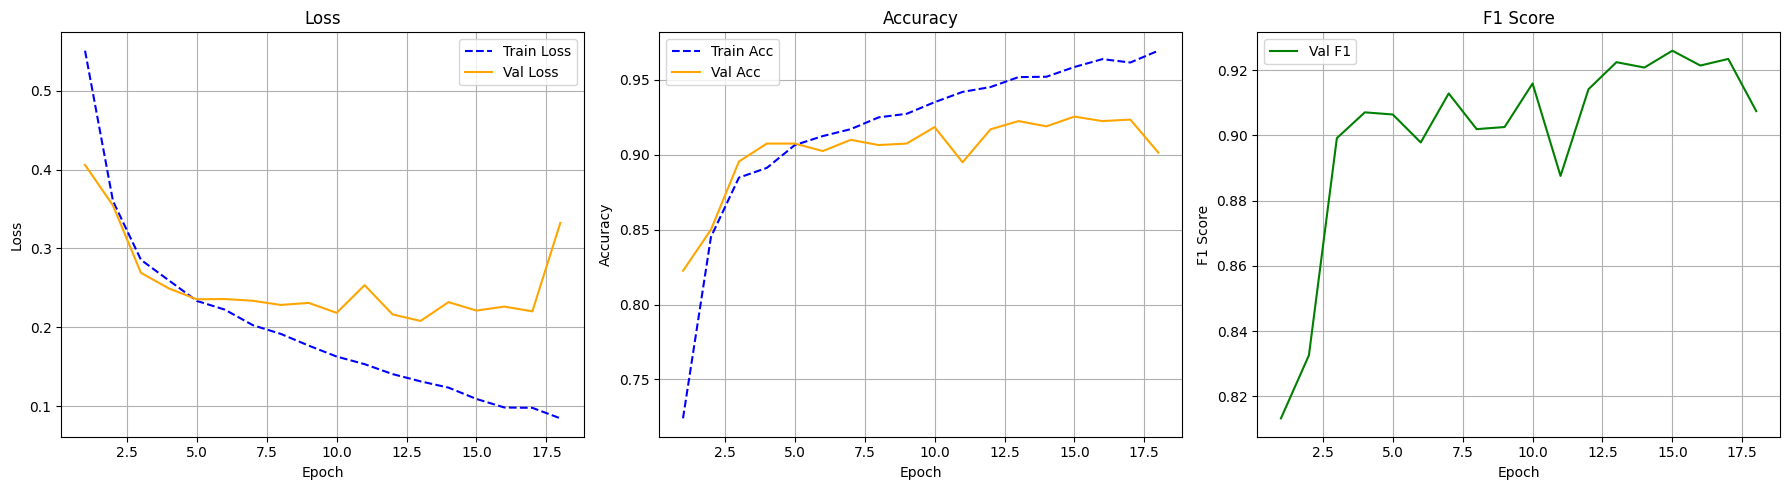

In [32]:
result = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accuracies": train_accuracies,
    "val_accuracies": val_accuracies,
    "val_f1s": val_f1s,
}

import matplotlib.pyplot as plt

epochs = range(1, len(result["train_losses"]) + 1)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(epochs, result["train_losses"], linestyle='--', label='Train Loss', color='blue')
axes[0].plot(epochs, result["val_losses"], label='Val Loss', color='orange')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(epochs, result["train_accuracies"], linestyle='--', label='Train Acc', color='blue')
axes[1].plot(epochs, result["val_accuracies"], label='Val Acc', color='orange')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(epochs, result["val_f1s"], label='Val F1', color='green')
axes[2].set_title('F1 Score')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


Processed 32 samples...
Accuracy: 0.7909799814224243
F1 Score: 0.788443383276329
Confusion Matrix:
 [[17037  7963]
 [ 2488 22512]]


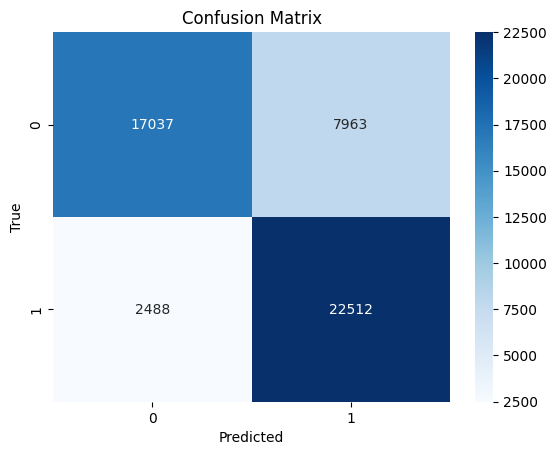

In [34]:
import matplotlib.pyplot as plt
results = test_worst(
            model,
            test_loader,
            criterion,
            return_preds=True,
            text_dataset=test_texts,
        )
print("Accuracy:", results["acc"])
print("F1 Score:", results["f1"])
print("Confusion Matrix:\n", results["confusion_matrix"])

# Plot confusion matrix
sns.heatmap(results["confusion_matrix"], annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix")
plt.show()

In [ ]:
df_wrong = results["misclassified"]

all_pos = df_wrong[df_wrong["true_label"] == "Positive"]
all_neg = df_wrong[df_wrong["true_label"] == "Negative"]

# Combine them
all_combined = pd.concat([all_pos, all_neg])

# Save to CSV
all_combined.to_csv("all_misclassified_BiLSTM_best_examples.csv", index=False)
average_length_test = IMDB_df['review'].str.len().mean()
print(f"avg len of test: {average_length_test}")

average_length_misclassified = all_combined['text'].str.len().mean()
print(f"avg len of misclassified: {average_length_misclassified}")

bad_predictions = all_combined[all_combined["pred_conf"]>0.75]
bad_preds_len = bad_predictions['text'].str.len().mean()
print(f"avg len of bad predictions: {bad_preds_len}")

close_predictions = all_combined[all_combined["pred_conf"]<=0.75]
close_preds_len =close_predictions['text'].str.len().mean()
print(f"avg len of close predictions: {close_preds_len}")



avg len of test: 1309.43102
avg len of misclassified: 1341.1050617165822
avg len of bad predictions: 1300.7300896982877
avg len of close predictions: 1437.153895893954


# CNN + LSTM hybrid model

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, output_size,
                 num_layers=1, dropout=0.3, method="avg", kernel_sizes=(3,4,5), cnn_channels=100):
        super(CNNLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, out_channels=cnn_channels, kernel_size=k)
            # nn.Conv1d(in_channels=embed_dim, out_channels=cnn_channels, kernel_size=k, padding=k//2)
            for k in kernel_sizes
        ])

        self.lstm = nn.LSTM(
            input_size=cnn_channels * len(kernel_sizes),
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.method = method

    def forward(self, x):
        """
        x: LongTensor (batch, seq_len)
        returns: logits (batch, output_size)
        """

        emb = self.embedding(x)
        emb_t = emb.transpose(1, 2)

        cnn_outs = []
        for conv in self.convs:
            c = F.relu(conv(emb_t))                     
            c = c.transpose(1, 2)                       
            cnn_outs.append(c)

        min_len = min(out.size(1) for out in cnn_outs)
        cnn_outs = [out[:, :min_len, :] for out in cnn_outs]
        cnn_cat = torch.cat(cnn_outs, dim=2)            

        lstm_out, _ = self.lstm(cnn_cat)                

        if self.method == "last":
            out = lstm_out[:, -1, :]                    
        elif self.method == "avg":
            out = lstm_out.mean(dim=1)                  
        elif self.method == "max":
            out, _ = lstm_out.max(dim=1)                
        else:
            raise ValueError(f"Unknown method: {self.method}")

        out = self.dropout(out)
        out = self.fc(out)                              
        return out

# Hyper param tuning

In [37]:
def hyperparam_tuning(lr, optimiser, weight_decay, method, kernel_sizes,cnn_channels):
    NUM_RUNS = 3
    all_results = []

    for run in range(1, NUM_RUNS + 1):
        print(f"\n{'='*25}\nStarting training run {run}\n{'='*25}")

        model = CNNLSTM(
            vocab_size=len(vocab), 
            embed_dim=embedding_matrix.shape[1], 
            hidden_size=128, 
            output_size=2, 
            method=method,
            kernel_sizes = kernel_sizes,
            cnn_channels = cnn_channels).to(device)


        # Load GloVe weights (frozen)
        model.embedding.weight.data.copy_(embedding_matrix)
        model.embedding.weight.requires_grad = False

        criterion = nn.CrossEntropyLoss()

        if optimiser.lower() == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimiser.lower() == "adamw":
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimiser.lower() == "sgd":
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9)
        

        best_acc = 0.0
        best_model_state = None
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies, val_f1s = [], [], []

        patience = 5
        best_val_loss = float('inf')
        epochs_no_improve = 0
        total_energy_usage = 0.0

        for epoch in range(50):
            train_loss, train_acc, energy_used = train_epoch(model, train_loader, optimizer, criterion)
            val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            val_f1s.append(val_f1)
            total_energy_usage += energy_used

            print(f"Epoch {epoch+1:02d}: "
                f"train loss={train_loss:.4f}, val loss={val_loss:.4f}, "
                f"train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, val_f1={val_f1:.4f}")

            if val_acc > best_acc:
                best_acc = val_acc
                best_model_state = copy.deepcopy(model.state_dict())
                print(f"New best accuracy: {best_acc:.4f} at epoch {epoch+1}, saving model.")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                print(f"No improvement in val loss for {epochs_no_improve} epochs.")
                if epochs_no_improve >= patience:
                    print(f"Early stopping triggered at epoch {epoch+1}.")
                    break

        model.load_state_dict(best_model_state)
        model.eval() 

        test_results = test_worst(
            model,
            test_loader,
            criterion,
            return_preds=True,
            text_dataset=test_texts,
        )

        all_results.append({
            "run": run,
            "num_epochs": epoch+1,
            "best_acc": best_acc,
            "total_energy": total_energy_usage,
            "train_losses": train_losses,
            "train_accuracies":train_accuracies,
            "val_accuracies":val_accuracies,
            "val_losses": val_losses,
            "val_f1s": val_f1s,
            "test_acc": test_results["acc"],
            "test_f1": test_results["f1"]
        })
    return all_results

# Tuning learning rate

In [25]:
learning_rates = [0.0001, 0.0005, 0.001]

best_avg_acc = 0.0
best_lr = None
all_lr_results = {}

for lr in learning_rates:
    print(f"\n{'='*40}\nTesting learning rate: {lr}\n{'='*40}")
    
    results = hyperparam_tuning(
        lr=lr, optimiser="adam", weight_decay=0.0,
        cnn_channels=100, kernel_sizes=(3,4,5), method="avg"
    )
    
    test_accs = [res["test_acc"] for res in results]
    test_f1s = [res["test_f1"] for res in results]
    
    avg_acc = sum(test_accs) / len(test_accs)
    avg_f1 = sum(test_f1s) / len(test_f1s)
    
    print(f"Test Accuracies for lr={lr}: {test_accs}")
    print(f"Test F1 Scores for lr={lr}: {test_f1s}")
    print(f"Average Test Accuracy: {avg_acc:.4f}, Average Test F1: {avg_f1:.4f}\n")
    
    all_lr_results[lr] = {
        "test_accs": test_accs,
        "test_f1s": test_f1s,
        "avg_acc": avg_acc,
        "avg_f1": avg_f1
    }
    
    # Update best configuration
    if avg_acc > best_avg_acc:
        best_avg_acc = avg_acc
        best_lr = lr

print(f"\n{'='*40}\nBest learning rate: {best_lr} with average test accuracy: {best_avg_acc:.4f}")





Testing learning rate: 0.0001

Starting training run 1
Epoch 01: train loss=0.6449, val loss=0.5730, train_acc=0.6186, val_acc=0.7230, val_f1=0.7583
New best accuracy: 0.7230 at epoch 1, saving model.
Epoch 02: train loss=0.5257, val loss=0.4882, train_acc=0.7661, val_acc=0.8040, val_f1=0.8112
New best accuracy: 0.8040 at epoch 2, saving model.
Epoch 03: train loss=0.4756, val loss=0.4576, train_acc=0.8037, val_acc=0.8300, val_f1=0.8335
New best accuracy: 0.8300 at epoch 3, saving model.
Epoch 04: train loss=0.4872, val loss=0.4426, train_acc=0.8069, val_acc=0.8220, val_f1=0.8353
Epoch 05: train loss=0.4682, val loss=0.4514, train_acc=0.8099, val_acc=0.8325, val_f1=0.8297
New best accuracy: 0.8325 at epoch 5, saving model.
No improvement in val loss for 1 epochs.
Epoch 06: train loss=0.4114, val loss=0.3937, train_acc=0.8414, val_acc=0.8445, val_f1=0.8378
New best accuracy: 0.8445 at epoch 6, saving model.
Epoch 07: train loss=0.4065, val loss=0.4094, train_acc=0.8478, val_acc=0.8555,

In [26]:
optimisers = ["adam", "adamw", "sgd"]  

best_avg_acc_opt = 0.0
best_optimiser = None
all_optimiser_results = {}

for opt in optimisers:
    print(f"\n{'='*40}\nTesting optimiser: {opt} with lr={best_lr}\n{'='*40}")
    
    results = hyperparam_tuning(
        lr=best_lr, optimiser=opt, weight_decay=0.0,
        cnn_channels=100, kernel_sizes=(3,4,5), method="avg"
    )
    
    test_accs = [res["test_acc"] for res in results]
    test_f1s = [res["test_f1"] for res in results]
    
    avg_acc = sum(test_accs) / len(test_accs)
    avg_f1 = sum(test_f1s) / len(test_f1s)
    
    print(f"Test Accuracies for optimiser={opt}: {test_accs}")
    print(f"Test F1 Scores for optimiser={opt}: {test_f1s}")
    print(f"Average Test Accuracy: {avg_acc:.4f}, Average Test F1: {avg_f1:.4f}\n")
    
    all_optimiser_results[opt] = {
        "test_accs": test_accs,
        "test_f1s": test_f1s,
        "avg_acc": avg_acc,
        "avg_f1": avg_f1
    }
    
    if avg_acc > best_avg_acc_opt:
        best_avg_acc_opt = avg_acc
        best_optimiser = opt

print(f"\n{'='*40}\nBest optimiser: {best_optimiser} with average test accuracy: {best_avg_acc_opt:.4f}")


Testing optimiser: adam with lr=0.0005

Starting training run 1
Epoch 01: train loss=0.5904, val loss=0.5518, train_acc=0.6869, val_acc=0.6960, val_f1=0.7623
New best accuracy: 0.6960 at epoch 1, saving model.
Epoch 02: train loss=0.4530, val loss=0.3970, train_acc=0.8096, val_acc=0.8440, val_f1=0.8537
New best accuracy: 0.8440 at epoch 2, saving model.
Epoch 03: train loss=0.3810, val loss=0.3847, train_acc=0.8485, val_acc=0.8580, val_f1=0.8457
New best accuracy: 0.8580 at epoch 3, saving model.
Epoch 04: train loss=0.3274, val loss=0.2865, train_acc=0.8701, val_acc=0.8920, val_f1=0.8881
New best accuracy: 0.8920 at epoch 4, saving model.
Epoch 05: train loss=0.3006, val loss=0.2827, train_acc=0.8850, val_acc=0.9060, val_f1=0.9058
New best accuracy: 0.9060 at epoch 5, saving model.
Epoch 06: train loss=0.2490, val loss=0.2620, train_acc=0.9070, val_acc=0.9130, val_f1=0.9132
New best accuracy: 0.9130 at epoch 6, saving model.
Epoch 07: train loss=0.2216, val loss=0.2619, train_acc=0.9

In [27]:
weight_decays = [0.0, 1e-5, 1e-4, 1e-3]

best_avg_acc_wd = 0.0
best_weight_decay = None
all_wd_results = {}

for wd in weight_decays:
    print(f"\n{'='*40}\nTesting weight decay: {wd} with lr={best_lr}, optimiser={best_optimiser}\n{'='*40}")
    
    results = hyperparam_tuning(
        lr=best_lr, optimiser=best_optimiser, weight_decay=wd,
        cnn_channels=100, kernel_sizes=(3,4,5), method="avg"
    )
    
    test_accs = [res["test_acc"] for res in results]
    test_f1s = [res["test_f1"] for res in results]
    
    avg_acc = sum(test_accs) / len(test_accs)
    avg_f1 = sum(test_f1s) / len(test_f1s)
    
    print(f"Test Accuracies for weight_decay={wd}: {test_accs}")
    print(f"Test F1 Scores for weight_decay={wd}: {test_f1s}")
    print(f"Average Test Accuracy: {avg_acc:.4f}, Average Test F1: {avg_f1:.4f}\n")
    
    all_wd_results[wd] = {
        "test_accs": test_accs,
        "test_f1s": test_f1s,
        "avg_acc": avg_acc,
        "avg_f1": avg_f1
    }
    
    if avg_acc > best_avg_acc_wd:
        best_avg_acc_wd = avg_acc
        best_weight_decay = wd

print(f"\n{'='*40}\nBest weight decay: {best_weight_decay} "
      f"with average test accuracy: {best_avg_acc_wd:.4f}")



Testing weight decay: 0.0 with lr=0.0005, optimiser=adamw

Starting training run 1
Epoch 01: train loss=0.5902, val loss=0.4960, train_acc=0.6941, val_acc=0.8160, val_f1=0.8132
New best accuracy: 0.8160 at epoch 1, saving model.
Epoch 02: train loss=0.4351, val loss=0.4274, train_acc=0.8267, val_acc=0.8275, val_f1=0.8445
New best accuracy: 0.8275 at epoch 2, saving model.
Epoch 03: train loss=0.4064, val loss=0.3488, train_acc=0.8406, val_acc=0.8700, val_f1=0.8660
New best accuracy: 0.8700 at epoch 3, saving model.
Epoch 04: train loss=0.3391, val loss=0.3285, train_acc=0.8695, val_acc=0.8815, val_f1=0.8732
New best accuracy: 0.8815 at epoch 4, saving model.
Epoch 05: train loss=0.3187, val loss=0.2874, train_acc=0.8822, val_acc=0.8975, val_f1=0.8983
New best accuracy: 0.8975 at epoch 5, saving model.
Epoch 06: train loss=0.2630, val loss=0.3118, train_acc=0.9010, val_acc=0.9000, val_f1=0.9036
New best accuracy: 0.9000 at epoch 6, saving model.
No improvement in val loss for 1 epochs.

In [29]:
cnn_channels_list = [50, 100, 150, 200]

best_avg_acc_ch = 0.0
best_ch = None
all_ch_results = {}

for ch in cnn_channels_list:
    print(f"\n{'='*40}\nTesting num_channels: {ch} with lr={best_lr}, optimiser={best_optimiser}, weight_Decay={best_weight_decay}\n{'='*40}")
    
    results = hyperparam_tuning(
        lr=best_lr, optimiser=best_optimiser, weight_decay=best_weight_decay,
        cnn_channels=ch, kernel_sizes=(3,4,5), method="avg"
    )
    
    test_accs = [res["test_acc"] for res in results]
    test_f1s = [res["test_f1"] for res in results]
    
    avg_acc = sum(test_accs) / len(test_accs)
    avg_f1 = sum(test_f1s) / len(test_f1s)
    
    print(f"Test Accuracies for num_channels={ch}: {test_accs}")
    print(f"Test F1 Scores for num_channels={ch}: {test_f1s}")
    print(f"Average Test Accuracy: {avg_acc:.4f}, Average Test F1: {avg_f1:.4f}\n")
    
    all_ch_results[ch] = {
        "test_accs": test_accs,
        "test_f1s": test_f1s,
        "avg_acc": avg_acc,
        "avg_f1": avg_f1
    }
    
    if avg_acc > best_avg_acc_ch:
        best_avg_acc_ch = avg_acc
        best_ch = ch

print(f"\n{'='*40}\nBest num_channels: {best_ch} "
      f"with average test accuracy: {best_avg_acc_ch:.4f}")



Testing num_channels: 50 with lr=0.0005, optimiser=adamw, weight_Decay=0.001

Starting training run 1
Epoch 01: train loss=0.6117, val loss=0.4935, train_acc=0.6620, val_acc=0.7840, val_f1=0.8118
New best accuracy: 0.7840 at epoch 1, saving model.
Epoch 02: train loss=0.4696, val loss=0.4882, train_acc=0.8135, val_acc=0.7750, val_f1=0.8109
Epoch 03: train loss=0.3875, val loss=0.3964, train_acc=0.8486, val_acc=0.8500, val_f1=0.8605
New best accuracy: 0.8500 at epoch 3, saving model.
Epoch 04: train loss=0.3503, val loss=0.4261, train_acc=0.8582, val_acc=0.8210, val_f1=0.8438
No improvement in val loss for 1 epochs.
Epoch 05: train loss=0.3341, val loss=0.3624, train_acc=0.8745, val_acc=0.8655, val_f1=0.8739
New best accuracy: 0.8655 at epoch 5, saving model.
Epoch 06: train loss=0.2788, val loss=0.3020, train_acc=0.8962, val_acc=0.8985, val_f1=0.9014
New best accuracy: 0.8985 at epoch 6, saving model.
Epoch 07: train loss=0.2654, val loss=0.2975, train_acc=0.9028, val_acc=0.8805, val_

In [30]:
kernel_size_sets = [(2,3,4), (3,4,5), (3,5,7)]

best_avg_acc_kernel_size = 0.0
best_kernel_size = None
all_kernel_size_results = {}

for ks in kernel_size_sets:
    print(f"\n{'='*40}\nTesting kernel_size: {ks} with lr={best_lr}, optimiser={best_optimiser}, weight_Decay={best_weight_decay}, num_channels={best_ch}\n{'='*40}")
    
    results = hyperparam_tuning(
        lr=best_lr, optimiser=best_optimiser, weight_decay=best_weight_decay,
        cnn_channels=best_ch, kernel_sizes=ks, method="avg"
    )
    
    test_accs = [res["test_acc"] for res in results]
    test_f1s = [res["test_f1"] for res in results]
    
    avg_acc = sum(test_accs) / len(test_accs)
    avg_f1 = sum(test_f1s) / len(test_f1s)
    
    print(f"Test Accuracies for kernel_size={ks}: {test_accs}")
    print(f"Test F1 Scores for kernel_size={ks}: {test_f1s}")
    print(f"Average Test Accuracy: {avg_acc:.4f}, Average Test F1: {avg_f1:.4f}\n")
    
    all_kernel_size_results[ks] = {
        "test_accs": test_accs,
        "test_f1s": test_f1s,
        "avg_acc": avg_acc,
        "avg_f1": avg_f1
    }
    
    if avg_acc > best_avg_acc_kernel_size:
        best_avg_acc_kernel_size = avg_acc
        best_kernel_size = ks

print(f"\n{'='*40}\nBest kernel_size: {best_kernel_size} "
      f"with average test accuracy: {best_avg_acc_kernel_size:.4f}")




Testing kernel_size: (2, 3, 4) with lr=0.0005, optimiser=adamw, weight_Decay=0.001, num_channels=50

Starting training run 1
Epoch 01: train loss=0.6399, val loss=0.5704, train_acc=0.6382, val_acc=0.7060, val_f1=0.7536
New best accuracy: 0.7060 at epoch 1, saving model.
Epoch 02: train loss=0.5013, val loss=0.4335, train_acc=0.7894, val_acc=0.8385, val_f1=0.8371
New best accuracy: 0.8385 at epoch 2, saving model.
Epoch 03: train loss=0.3959, val loss=0.3973, train_acc=0.8436, val_acc=0.8440, val_f1=0.8276
New best accuracy: 0.8440 at epoch 3, saving model.
Epoch 04: train loss=0.3545, val loss=0.3279, train_acc=0.8635, val_acc=0.8760, val_f1=0.8679
New best accuracy: 0.8760 at epoch 4, saving model.
Epoch 05: train loss=0.3123, val loss=0.2922, train_acc=0.8866, val_acc=0.8965, val_f1=0.8938
New best accuracy: 0.8965 at epoch 5, saving model.
Epoch 06: train loss=0.2863, val loss=0.2731, train_acc=0.8914, val_acc=0.9010, val_f1=0.8977
New best accuracy: 0.9010 at epoch 6, saving model

In [31]:
methods = ["last", "avg", "max"]

best_avg_acc_method = 0.0
best_method = None
all_method_results = {}

for method in methods:
    print(f"\n{'='*40}\nTesting method: {method} with lr={best_lr}, optimiser={best_optimiser}, weight_Decay={best_weight_decay}, num_channels={best_ch}, kernel_sze={best_kernel_size} \n{'='*40}")
    
    results = hyperparam_tuning(
        lr=best_lr, optimiser=best_optimiser, weight_decay=best_weight_decay,
        cnn_channels=best_ch, kernel_sizes=best_kernel_size, method=method
    )
    
    test_accs = [res["test_acc"] for res in results]
    test_f1s = [res["test_f1"] for res in results]
    
    avg_acc = sum(test_accs) / len(test_accs)
    avg_f1 = sum(test_f1s) / len(test_f1s)
    
    print(f"Test Accuracies for method={method}: {test_accs}")
    print(f"Test F1 Scores for method={method}: {test_f1s}")
    print(f"Average Test Accuracy: {avg_acc:.4f}, Average Test F1: {avg_f1:.4f}\n")
    
    all_method_results[method] = {
        "test_accs": test_accs,
        "test_f1s": test_f1s,
        "avg_acc": avg_acc,
        "avg_f1": avg_f1
    }
    
    if avg_acc > best_avg_acc_method:
        best_avg_acc_method = avg_acc
        best_method = method

print(f"\n{'='*40}\nBest method: {best_method} "
      f"with average test accuracy: {best_avg_acc_method:.4f}")







Testing method: last with lr=0.0005, optimiser=adamw, weight_Decay=0.001, num_channels=50, kernel_sze=(3, 4, 5) 

Starting training run 1
Epoch 01: train loss=0.6910, val loss=0.6903, train_acc=0.5008, val_acc=0.5000, val_f1=0.0000
New best accuracy: 0.5000 at epoch 1, saving model.
Epoch 02: train loss=0.6896, val loss=0.6896, train_acc=0.5080, val_acc=0.5130, val_f1=0.6676
New best accuracy: 0.5130 at epoch 2, saving model.
Epoch 03: train loss=0.6896, val loss=0.6891, train_acc=0.5086, val_acc=0.5125, val_f1=0.6673
Epoch 04: train loss=0.6885, val loss=0.6917, train_acc=0.5146, val_acc=0.5135, val_f1=0.6678
New best accuracy: 0.5135 at epoch 4, saving model.
No improvement in val loss for 1 epochs.
Epoch 05: train loss=0.6866, val loss=0.6910, train_acc=0.5118, val_acc=0.5135, val_f1=0.6676
No improvement in val loss for 2 epochs.
Epoch 06: train loss=0.6862, val loss=0.6942, train_acc=0.5102, val_acc=0.5135, val_f1=0.6676
No improvement in val loss for 3 epochs.
Epoch 07: train lo

In [ ]:
print("BEST TRAINING CONFIGURATION:")
print(f"Learning Rate : {best_lr}")
print(f"Optimizer     : {best_optimiser}")
print(f"Weight Decay  : {best_weight_decay}")
print(f"CNN Channels  : {best_ch}")
print(f"Kernel Sizes  : {best_kernel_size}")
print(f"Method        : {best_method}")

BEST TRAINING CONFIGURATION:
Learning Rate : 0.0005
Optimizer     : adamw
Weight Decay  : 0.001
CNN Channels  : 50
Kernel Sizes  : (3,4,5)
Method        : max


In [42]:
model = CNNLSTM(
    vocab_size=len(vocab), 
    embed_dim=embedding_matrix.shape[1], 
    hidden_size=128, 
    output_size=2, 
    method=best_method,
    kernel_sizes = best_kernel_size,
    cnn_channels = best_ch).to(device)


# Load GloVe weights (frozen)
model.embedding.weight.data.copy_(embedding_matrix)
model.embedding.weight.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)


tracker = CarbonTracker(epochs=50, log_dir="./carbon_logs", components="all")

best_acc = 0.0
best_model_state = None
train_losses, val_losses = [], []
train_accuracies, val_accuracies, val_f1s = [], [], []

patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
total_energy_usage = 0.0

for epoch in range(50):

    tracker.epoch_start()

    train_loss, train_acc, energy_used = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion)

    tracker.epoch_end()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)
    total_energy_usage += energy_used
        

    print(f"Epoch {epoch+1:02d}: "
        f"train loss={train_loss:.4f}, val loss={val_loss:.4f}, "
        f"train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, val_f1={val_f1:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        print(f"New best accuracy: {best_acc:.4f} at epoch {epoch+1}, saving model.")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement in val loss for {epochs_no_improve} epochs.")
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break
tracker.stop()  

print("Carbon tracking complete. Logs saved in './carbon_logs'.")

CarbonTracker: INFO - Detected CPU: 13th Gen Intel(R) Core(TM) i9-13900H
CarbonTracker: WARNING - No matching TDP found for CPU: 13th Gen Intel(R) Core(TM) i9-13900H. Using average TDP of 35.61W at 50% utilization as fallback.
CarbonTracker: WARNING - No API keys provided. Skipping intensity provider initialization.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce RTX 3050 4GB Laptop GPU. CPU with device(s) 13th Gen Intel(R) Core(TM) i9-13900H.
CarbonTracker: WARNING - No carbon intensity provider specified. Using average carbon intensity for SG: 498.74 gCO2eq/kWh.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	0:24:59
	Energy:	0.037068318685 kWh
	CO2eq:	18.487520725507 g
	This is equivalent to:
	0.173104126643 km travelled by car
Epoch 01: train loss=0.5823, val loss=0.5562, train_acc=0.6869, val_acc=0.7025, val_f1=0.7664
New best accuracy: 0.7025 at epoch 1, saving model.
Epoch 02: train loss=0.3759, val loss=0.3052, train_acc=0.837

In [43]:
latest_file = get_latest_carbontracker_output()
results = parse_carbontracker_log(latest_file)

print("Latest CarbonTracker file:", latest_file)
print("Energy consumed (kWh):", results["energy_kWh"])
print("CO2eq (g):", results["co2_grams"])
print("Car travelled equivalent (km):", results["car_km"])

Latest CarbonTracker file: carbon_logs\8100.595734_2025-11-14T144907Z_carbontracker_output.log
Energy consumed (kWh): 0.037068318685
CO2eq (g): 18.487520725507
Car travelled equivalent (km): 0.173104126643


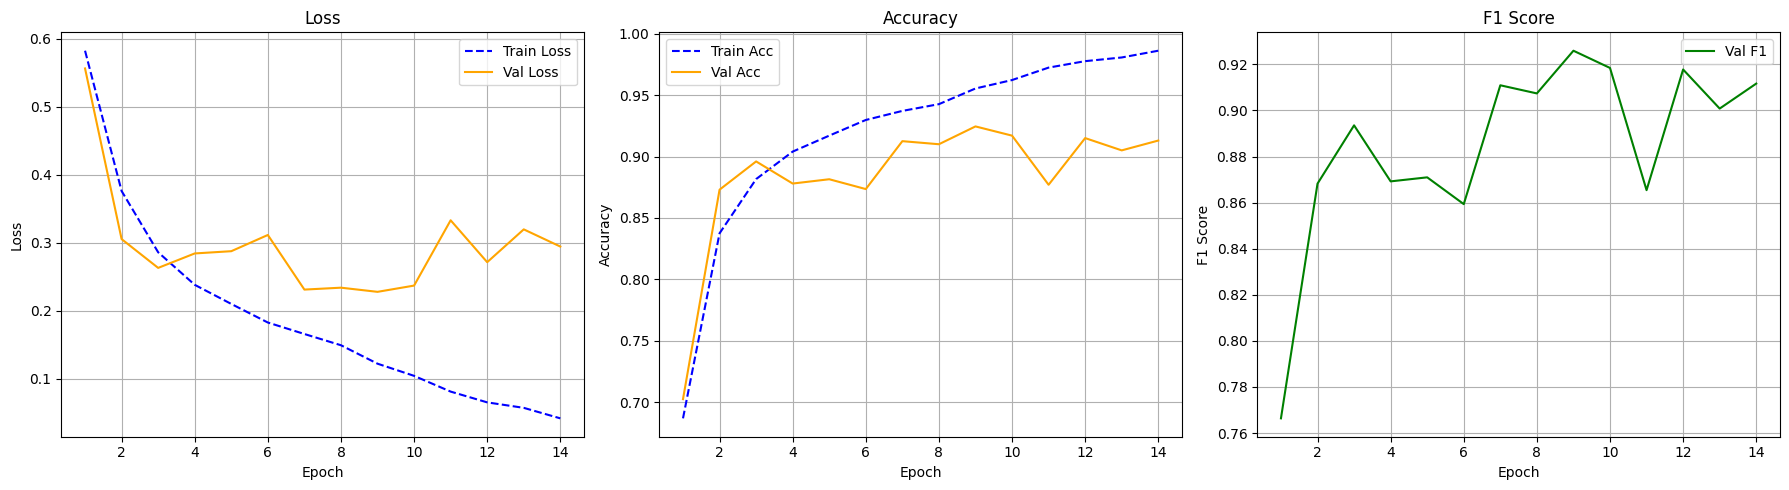

In [44]:
result = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accuracies": train_accuracies,
    "val_accuracies": val_accuracies,
    "val_f1s": val_f1s,
}

import matplotlib.pyplot as plt

epochs = range(1, len(result["train_losses"]) + 1)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(epochs, result["train_losses"], linestyle='--', label='Train Loss', color='blue')
axes[0].plot(epochs, result["val_losses"], label='Val Loss', color='orange')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(epochs, result["train_accuracies"], linestyle='--', label='Train Acc', color='blue')
axes[1].plot(epochs, result["val_accuracies"], label='Val Acc', color='orange')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(epochs, result["val_f1s"], label='Val F1', color='green')
axes[2].set_title('F1 Score')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


Processed 32 samples...
Accuracy: 0.788860023021698
F1 Score: 0.7883235875009341
Confusion Matrix:
 [[20980  4020]
 [ 6537 18463]]


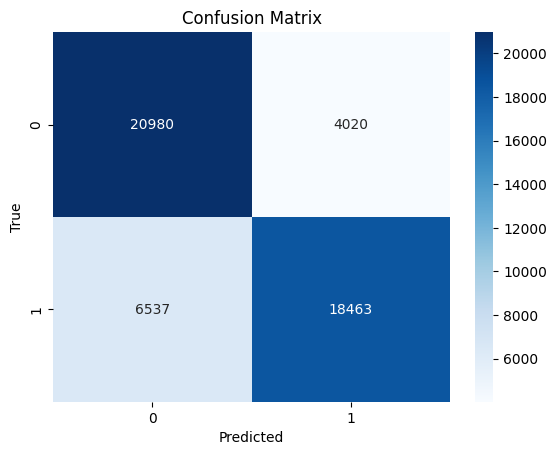

In [45]:
import matplotlib.pyplot as plt
results = test_worst(
            model,
            test_loader,
            criterion,
            return_preds=True,
            text_dataset=test_texts,
        )
print("Accuracy:", results["acc"])
print("F1 Score:", results["f1"])
print("Confusion Matrix:\n", results["confusion_matrix"])

# Plot confusion matrix
sns.heatmap(results["confusion_matrix"], annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix")
plt.show()

In [46]:
df_wrong = results["misclassified"]

all_pos = df_wrong[df_wrong["true_label"] == "Positive"]
all_neg = df_wrong[df_wrong["true_label"] == "Negative"]

# Combine them
all_combined = pd.concat([all_pos, all_neg])

# Save to CSV
all_combined.to_csv("all_misclassified_CLSTM_best_examples.csv", index=False)
average_length_test = IMDB_df['review'].str.len().mean()
print(f"avg len of test: {average_length_test}")

average_length_misclassified = all_combined['text'].str.len().mean()
print(f"avg len of misclassified: {average_length_misclassified}")

bad_predictions = all_combined[all_combined["pred_conf"]>0.75]
bad_preds_len = bad_predictions['text'].str.len().mean()
print(f"avg len of bad predictions: {bad_preds_len}")

close_predictions = all_combined[all_combined["pred_conf"]<=0.75]
close_preds_len =close_predictions['text'].str.len().mean()
print(f"avg len of close predictions: {close_preds_len}")



avg len of test: 1309.43102
avg len of misclassified: 1420.9912854030501
avg len of bad predictions: 1415.0147301587301
avg len of close predictions: 1438.5398956002982
